# Dealing with class imbalance

Class imbalance is a major problem in any __"real-world"__ classification task.

Assume you are dealing with classifying violence vs non-violence scenarios from video sequences streaming from a security camera, and the task of this camera is to identify __violence__ vs __non-Violence__ scenarios. We all know that 
$99.9\%$ of the time, security camera record the "normal" (non-violence) scenarios while detecting "violence" behavior can be considered as a rare event.

Similarly in the medical diagnosis use case for a rare disease, in this case we generally dealing with highly "imbalance" samples.

In this tutorial you will learn about:
    
    1. Effect of class imbalance on your model training
    2.  Major techniques to deal with the class imbalance:
        Oversampling
        

In this tutorial similar to the provious one we will work with the Malaria Dataset. However, to simulate the class imbalance we extract a subset from the dataset such that the ratio between the positive class "infected" and negative class "uninfected" is 100/1000 for training and 10/90 for the validation set.

# Steps to establish a machine learning pipeline for this tutorial
1. Dataloading and shaping an imbalance dataset
2. Torch ready data prepration
3. Model definition
4. Optimizer and loss definition
5. Training and validation

In [1]:
import torch
import os
import pandas as pd
import numpy as np
import seaborn as sns

from monai.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from monai.transforms import (
    Compose,
    LoadImaged, 
    AddChanneld, 
    RandFlipd, 
    RandRotate90d, 
    Resized, 
    EnsureChannelFirstd,
    RandGaussianNoised,
    ToTensord
    )
import torch.optim as optim
import torch.nn as nn

## Dataloading and creating an imbalance dataset

In [2]:
root_dir = '/home/sadegh_mohammadi/data/cell_images/'
infected_name = 'Parasitized'
uninfected_name = 'Uninfected'
df_infected = pd.DataFrame({'image_name':os.listdir(os.path.join(root_dir,infected_name)), 
                          'folder_name': [infected_name for _ in range(len(os.listdir(os.path.join(root_dir,infected_name))))],
                         'label': [1 for _ in range(len(os.listdir(os.path.join(root_dir,infected_name))))]})

df_uninfected = pd.DataFrame({'image_name':os.listdir(os.path.join(root_dir,uninfected_name)), 
                            'folder_name': [uninfected_name for _ in range(len(os.listdir(os.path.join(root_dir,uninfected_name))))],
                             'label': [0 for _ in range(len(os.listdir(os.path.join(root_dir,uninfected_name))))]})

# select the subset of the data
df_infected_sample = df_infected.sample(n=300, random_state=0).reset_index()
df_uninfected_sample = df_uninfected.sample(n= 10100, random_state=0).reset_index()

# Create the train/test split
# train
df_infected_train = df_infected_sample.loc[0:49]
df_uninfected_train = df_uninfected_sample.loc[0:9849]
df_list = [df_infected_train, df_uninfected_train]
df_train = pd.concat(df_list).reset_index()
# test
df_infected_test = df_infected_sample.loc[50:]
df_uninfected_test = df_uninfected_sample.loc[9850:]

df_list = [df_infected_test, df_uninfected_test]
df_val = pd.concat(df_list).reset_index()


print('number of infected samples is {} and number of unifected is {}'.format(len(df_infected), len(df_uninfected)))
print('number of train samples is {} and number of test is {}'.format(len(df_train), len(df_val)))



number of infected samples is 13780 and number of unifected is 13779
number of train samples is 9900 and number of test is 500


In [4]:
len(df_train)

9900

### Distribution of training set tolist

50 9850


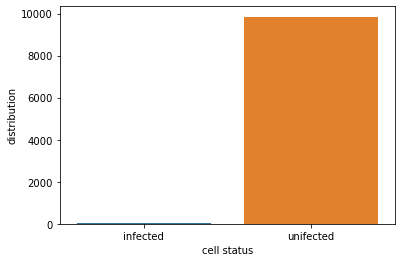

In [5]:
num_infected = len(df_train[df_train['label'] == 1])
num_uninfected = len(df_train[df_train['label'] == 0])
df_num = pd.DataFrame({'cell status':['infected','unifected'], 'distribution':[num_infected, num_uninfected]}, columns=['cell status', 'distribution'])
print(num_infected, num_uninfected)
ax = sns.barplot(x="cell status", y="distribution", data=df_num)

### Weight computation, for oversampling and also penalization

In [6]:
target = df_train['label'].to_numpy()
class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

## Helper function to shape the training and validation set in an acceptable Monai format

In [7]:
def list2dict(df):
    data_dict = {}
    list_of_dict = []
    for i in range(0,len(df)):
        #data_dict['image'] = os.path.join(root_dir,df.iloc[i,1],df.iloc[i,0])
        data_dict['image'] = os.path.join(root_dir,df['folder_name'][i],df['image_name'][i])
        data_dict['label'] = df['label'][i]
        list_of_dict.append(data_dict.copy())
    return list_of_dict
data_train = list2dict(df_train)
data_val = list2dict(df_val)

### Torch ready transformation, Monai plugin

In [8]:


train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Resized(keys=["image"],spatial_size=(224,224)),
        RandFlipd(keys=["image"], prob=0.5),
        RandRotate90d(keys=["image"], prob=0.5),
        RandGaussianNoised(keys=["image"], prob=0.2),
        ToTensord(keys=["image"])
])

val_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Resized(keys=["image"],spatial_size=(224,224)),
        ToTensord(keys=["image"])
])



### Dataloader

In [16]:
oversampling = True

ds_tr = Dataset(data=data_train,transform= train_transforms) # create dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
if oversampling == True:
    ds_tr_loader = DataLoader(ds_tr, batch_size=100, sampler =sampler,**kwargs)
else:
    ds_tr_loader = DataLoader(ds_tr, batch_size=100, shuffle = True, **kwargs)

ds_val = Dataset(data=data_val,transform= val_transforms) # create dataset
ds_val_loader = DataLoader(ds_val, batch_size=len(ds_val),shuffle = True, **kwargs)

len(ds_tr), len(ds_val) 

(9900, 500)

In [10]:
for i, batch in enumerate(ds_tr_loader):
    target = batch['label']
    print ("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))

batch index 0, 0/1: 47/53
batch index 1, 0/1: 56/44
batch index 2, 0/1: 48/52


KeyboardInterrupt: 

# Define model, we use Resnet 50 for this purpose!

In [17]:
from torchvision import datasets, models
#net = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
net = models.resnet18(pretrained=True)
#net.fc = nn.Linear(in_features=2048, out_features=2) # only last year needed to be replace
#net.to(device)
num_ftrs = net.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
net.fc = nn.Linear(num_ftrs, 2)
net.to(device)

print()

## Define Optimizer and loss function

In [18]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
#penalization = False
#if penalization == True:
 #   penalization_weight = np.min(class_sample_count)/class_sample_count  #  Weight of class C is the size of smallest class divided by the size of class C, Alternatively you can divide the size of the largest class and divide them in the class C
  #  penalization_weight = (torch.from_numpy(penalization_weight).float()).to(device)
   # criterion = nn.CrossEntropyLoss(penalization_weight)
#else:
criterion = nn.CrossEntropyLoss()

# training/validation

In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc



tracker = dict()
accuracy_tr = list()
loss_tr = list()
accuracy_val = list()
loss_val = list()
auc_tr = list()
auc_val = list()
conf_tr = list()
conf_te = list()

epochs = 5
for epoch in range(epochs):
    pred_iter = list()
    target_iter = list()
    accuracy_tr_iter = list()
    running_loss_tr = 0
    total_data_tr = 0
    running_loss_te = 0
    total_data_te = 0
    net.train()
    for i, batch in enumerate(ds_tr_loader):
        data = batch['image'].to(device)
        target = batch['label'].to(device)
        outputs = net(data)
        _,preds = torch.max(outputs,1)
        optimizer.zero_grad()
        loss = criterion(outputs, target)
        #print ("batch index {}, 0/1: {}/{}".format(
        #i,
        #len(np.where(target.cpu().numpy() == 0)[0]),
        #len(np.where(target.cpu().numpy() == 1)[0])))

        loss.backward()
        optimizer.step()
        
        pred_iter.extend(preds.detach().cpu().numpy())
        target_iter.extend(target.detach().cpu().numpy())
        running_loss_tr += loss.item() * data.size(0)
        total_data_tr += data.size(0)
        loss.detach()
    
    epoch_loss = running_loss_tr / total_data_tr
    loss_tr.append(epoch_loss)
    
    fpr, tpr, thresholds = roc_curve(target_iter, pred_iter)
    AUC = auc(fpr, tpr)
    ACC = accuracy_score(target_iter,pred_iter)
    conf_tr.append(confusion_matrix(target_iter,pred_iter))
    auc_tr.append(AUC)
    accuracy_tr.append(ACC)
    
    
    print('training Phase: epoch: {} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(
                epoch , epoch_loss, ACC, AUC))
    
    net.eval()
    with torch.no_grad():
        for i, batch in enumerate(ds_val_loader):
            data = batch['image'].to(device)
            target = batch['label'].to(device)
            outputs = net(data)
            _,preds = torch.max(outputs,1)
            #loss = criterion(outputs, target)

            #running_loss_te += loss.item() * data.size(0)
            #total_data_te += data.size(0)
        #epoch_loss = running_loss_te / total_data_te
        #loss_val.append(epoch_loss)

        fpr, tpr, thresholds = roc_curve(target.detach().cpu().numpy(), preds.detach().cpu().numpy())
        AUC = auc(fpr, tpr)
        ACC = accuracy_score(target.detach().cpu().numpy(), preds.detach().cpu().numpy())
        auc_val.append(AUC)
        accuracy_val.append(ACC)
        conf_te.append(confusion_matrix(target.detach().cpu().numpy(), preds.detach().cpu().numpy()))
        print('validation Phase: epoch: {} Loss: {:.2f} Acc: {:.2f} AUC: {:.2f}'.format(
                        epoch , epoch_loss, ACC, AUC))

tracker['loss_tr'] = loss_tr
tracker['loss_val'] = loss_val
tracker['accuracy_tr'] = accuracy_tr
tracker['accuracy_val'] = accuracy_val
tracker['auc_tr'] = auc_tr
tracker['auc_val'] = auc_val
tracker['conf_tr'] = conf_tr
tracker['conf_te'] = conf_te

import pickle

with open('tracker_No_oversampling.pickle', 'wb') as f:
    pickle.dump(tracker,f)

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

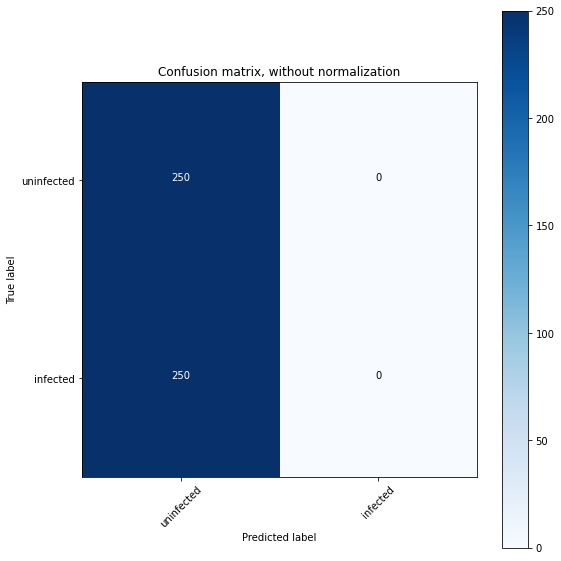

<Figure size 432x288 with 0 Axes>

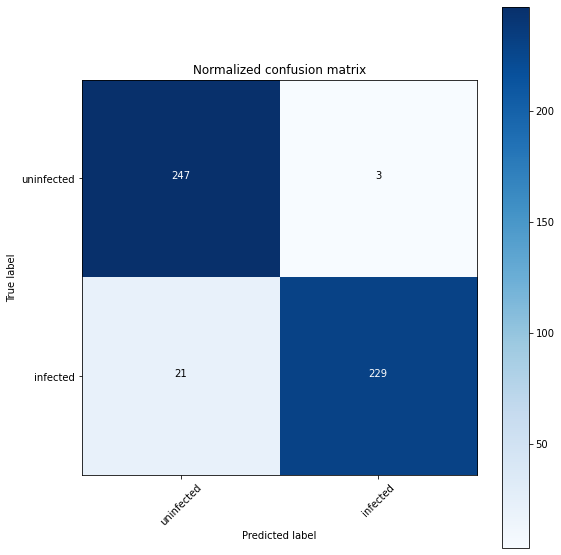

In [22]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

class_names = ['uninfected', 'infected']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm,2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#cnf_matrix = best_conf.mean(2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(tracker_no_oversampling['conf_te'][1], classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(tracker['conf_te'][1], classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

plt.show()